In [1]:
PATH = '/Users/siddhantthakur/pizza req/'

from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from statistics import mean
from prettytable import PrettyTable

import matplotlib.pyplot as plt
import shap

import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

np.set_printoptions(suppress=True)

RANDOM_STATE = 4

In [2]:
# certificate verification fail

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/siddhantthakur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
with open(PATH + 'pizza_request_dataset/pizza_request_dataset.json', 'r') as f:
    data = json.load(f)

In [5]:
len(data)

5671

In [6]:
sorted(data[0].keys())

['giver_username_if_known',
 'in_test_set',
 'number_of_downvotes_of_request_at_retrieval',
 'number_of_upvotes_of_request_at_retrieval',
 'post_was_edited',
 'request_id',
 'request_number_of_comments_at_retrieval',
 'request_text',
 'request_text_edit_aware',
 'request_title',
 'requester_account_age_in_days_at_request',
 'requester_account_age_in_days_at_retrieval',
 'requester_days_since_first_post_on_raop_at_request',
 'requester_days_since_first_post_on_raop_at_retrieval',
 'requester_number_of_comments_at_request',
 'requester_number_of_comments_at_retrieval',
 'requester_number_of_comments_in_raop_at_request',
 'requester_number_of_comments_in_raop_at_retrieval',
 'requester_number_of_posts_at_request',
 'requester_number_of_posts_at_retrieval',
 'requester_number_of_posts_on_raop_at_request',
 'requester_number_of_posts_on_raop_at_retrieval',
 'requester_number_of_subreddits_at_request',
 'requester_received_pizza',
 'requester_subreddits_at_request',
 'requester_upvotes_minus

In [7]:
success = [d['requester_received_pizza'] for d in data]
print("Average Success Rate",str(sum(success)/len(success)*100))

Average Success Rate 24.634103332745546


In [8]:
for d in data:
    d['upvotes_minus_downvotes'] = d['number_of_upvotes_of_request_at_retrieval'] - d['number_of_downvotes_of_request_at_retrieval']

for d in data:
    d['final_request_text'] = d['request_title'] + " " + d['request_text_edit_aware']

In [9]:
data[0]

{'giver_username_if_known': 'N/A',
 'in_test_set': False,
 'number_of_downvotes_of_request_at_retrieval': 2,
 'number_of_upvotes_of_request_at_retrieval': 6,
 'post_was_edited': False,
 'request_id': 't3_w5491',
 'request_number_of_comments_at_retrieval': 7,
 'request_text': "I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lately. I'm a 36 year old single guy with a job. But rent, and other bills killed me this month. I thought I had enough funds in my account to at least keep me set with Mr. Noodles, I forgot about my monthly banking fee.\n\nI had a small bag of chips Wednesday afternoon, and I get paid Monday, so I'll be fine then.. It's just really painful at this point and food is something I'm constantly thinking about.\n\nI've got a few bucks to get on the bus to work on Saturday, so I can't really use that.\n\nI'm really embarrassed to even be asking like this and I'm not sure how it works, so please be patient with me.\n\nI guess tha

In [10]:
df = pd.json_normalize(data)
df['requester_received_pizza'] = df['requester_received_pizza'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,giver_username_if_known,in_test_set,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,upvotes_minus_downvotes,final_request_text
0,N/A,False,0,2,True,t3_p7iuv,6,http://i43.tinypic.com/vcqe6s.jpg - Doctors ce...,http://i43.tinypic.com/vcqe6s.jpg - Doctors ce...,"[REQUEST] I'm sick, it hurts to talk and just ...",...,336,1127,678,2461,shroom,KamiKazilik,1.328176e+09,1.328176e+09,2,"[REQUEST] I'm sick, it hurts to talk and just ..."
1,N/A,True,0,3,False,t3_sydf2,1,I missed two weeks of work earlier this month ...,I missed two weeks of work earlier this month ...,[Request][Indiana] Been living on ramen and sp...,...,1410,6096,2032,8372,shroom,Goluxas,1.335725e+09,1.335721e+09,3,[Request][Indiana] Been living on ramen and sp...
2,N/A,False,0,3,False,t3_n474p,0,"I'm going to be up pretty late tonight, and so...","I'm going to be up pretty late tonight, and so...",[REQUEST] Two final exams and a final paper to...,...,1250,7854,4728,13834,None,celticsbig4,1.323310e+09,1.323310e+09,3,[REQUEST] Two final exams and a final paper to...
3,scott2chicago,False,3,6,False,t3_1kjz61,7,I just got hired on as a member of Geek Squad ...,I just got hired on as a member of Geek Squad ...,"[Request] Longview, TX; I just got a job! Chec...",...,231,459,381,771,shroom,Satheling,1.376759e+09,1.376756e+09,3,"[Request] Longview, TX; I just got a job! Chec..."
4,N/A,True,6,7,1367544858.0,t3_1dlaly,5,Every other paycheck goes almost entirely to r...,Every other paycheck goes almost entirely to r...,[Request] Chicago- Spent my last $20 on food f...,...,23,23,35,57,None,junefirst123,1.367548e+09,1.367544e+09,1,[Request] Chicago- Spent my last $20 on food f...


In [11]:
df['requester_received_pizza'].isna().sum()

0

In [12]:
# text preprocessing
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def process_text(text):
    text = text.replace("\n"," ").replace("\r"," ")
    text = re.sub(r'“', " '' ", text)
    text = re.sub(r'”', " '' ", text)
    text = re.sub(r'"', " '' ", text)
    text = re.sub(r'(\S)(\'\')', r'\1 \2 ', text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    punc_list = '!"#$%()*+,-./:;<=>?@^_{|}~[]'
    t = str.maketrans(dict.fromkeys(punc_list," "))
    text = text.translate(t)
    
    t = str.maketrans(dict.fromkeys("'`",""))
    text = text.translate(t)
    
    text = text.lower()
    
    tokens = regexp_tokenize(text,pattern='\s+',gaps=True)
    cleaned_tokens = []
    
    for t in tokens:
        if t not in stopwords_eng:
            l = lemmatizer.lemmatize(t)
            cleaned_tokens.append(l)
    
    return cleaned_tokens

In [13]:
process_text(df['final_request_text'][0])

['request',
 'sick',
 'hurt',
 'talk',
 'everything',
 'else',
 'pizza',
 'wont',
 'make',
 'better',
 'physically',
 'sure',
 'would',
 'make',
 'feel',
 'better',
 'http',
 'i43',
 'tinypic',
 'com',
 'vcqe6s',
 'jpg',
 'doctor',
 'certificate',
 'included',
 'live',
 'melbourne',
 'australia']

In [14]:
# 20% split for train and test data
train_set = df.loc[:4536,:]
test_set = df.loc[4537:,:].reset_index(drop=True)
print(train_set.shape)
print(test_set.shape)

(4537, 35)
(1134, 35)


In [15]:
final_df = df.loc[:,['upvotes_minus_downvotes','requester_account_age_in_days_at_request','request_number_of_comments_at_retrieval']]
final_df['length_of_text'] = df.apply(lambda r: len(r['final_request_text']), axis = 1)
final_df['evidence_link'] = df.apply(lambda r: 1 if re.findall(r'(?:http\:|https\:)?\/\/.*\.',r['final_request_text']) else 0, axis = 1)
final_df['requester_posted_before'] = df.apply(lambda r: 0 if r['requester_days_since_first_post_on_raop_at_request']==0 else 1, axis = 1)
final_df['requester_received_pizza'] = df.loc[:,'requester_received_pizza']

final_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,2,125.174259,6,247,1,1,1
1,3,862.983495,1,432,0,0,1
2,3,101.920671,0,238,0,1,0
3,3,159.823935,7,337,0,1,1
4,1,80.338808,5,417,0,0,0
...,...,...,...,...,...,...,...
5666,6,212.977292,4,456,0,0,0
5667,15,338.554259,0,383,0,1,0
5668,1,184.172870,3,300,0,1,1
5669,2,404.469190,0,366,0,0,1


In [16]:
final_train_set = final_df.loc[:4536,:]
final_test_set = final_df.loc[4537:,:].reset_index(drop=True)
print(final_train_set.shape)
print(final_test_set.shape)

(4537, 7)
(1134, 7)


## Random Forest based Count Model

In [17]:
new_count_vec = CountVectorizer(analyzer=process_text)
new_count_df = new_count_vec.fit_transform(train_set['final_request_text'])
new_count_labels = train_set['requester_received_pizza']

print(new_count_df.shape)

(4537, 12667)


In [18]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_count_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_count_model_nbg = GaussianNB()
new_count_model_nbm = MultinomialNB()
new_count_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_count_model_lr_accuracy_score = []
new_count_model_nbg_accuracy_score = []
new_count_model_nbm_accuracy_score = []
new_count_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_count_df, new_count_labels):
    X_train, X_test = new_count_df[train_index], new_count_df[test_index]
    y_train, y_test = new_count_labels[train_index], new_count_labels[test_index]
    
    new_count_model_lr.fit(X_train,y_train)
    new_count_model_lr_accuracy_score.append(accuracy_score(y_test,new_count_model_lr.predict(X_test)))

    new_count_model_nbg.fit(X_train.toarray(),y_train)
    new_count_model_nbg_accuracy_score.append(accuracy_score(y_test,new_count_model_nbg.predict(X_test.toarray())))
    
    new_count_model_nbm.fit(X_train,y_train)
    new_count_model_nbm_accuracy_score.append(accuracy_score(y_test,new_count_model_nbm.predict(X_test)))
    
    new_count_model_rf.fit(X_train,y_train)
    new_count_model_rf_accuracy_score.append(accuracy_score(y_test,new_count_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_count_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_count_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_count_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_count_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.622872966323385
Gaussian NB,0.5082552926646634
Multinomial NB,0.7172156256381831
Random Forest,0.7546838988242844


In [19]:
new_final_count_rf_df = final_train_set.copy()
new_count_rf_est_prob = new_count_model_rf.predict_proba(new_count_df)[:,1]
new_final_count_rf_df.insert(5,'prob_from_text',new_count_rf_est_prob)
new_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,125.174259,6,247,1,0.395515,1,1
1,3,862.983495,1,432,0,0.537688,0,1
2,3,101.920671,0,238,0,0.173170,1,0
3,3,159.823935,7,337,0,0.362132,1,1
4,1,80.338808,5,417,0,0.207419,0,0
...,...,...,...,...,...,...,...,...
4532,21,32.851157,13,665,0,0.708278,0,1
4533,2,379.848507,0,405,0,0.179390,0,0
4534,1,125.273750,0,667,0,0.193505,0,0
4535,1,29.702674,0,200,0,0.141488,0,0


In [20]:
new_final_count_rf_df = new_final_count_rf_df.sample(frac=1).reset_index(drop=True)
new_final_count_rf_labels = new_final_count_rf_df.iloc[:,-1]
new_final_count_rf_df = new_final_count_rf_df.iloc[:,:-1]
new_final_count_rf_labels

0       0
1       0
2       0
3       0
4       0
       ..
4532    0
4533    0
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [21]:
new_skfold_final_count_rf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_final_count_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_count_rf_model_nbg = GaussianNB()
new_final_count_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_count_rf_model_lr_accuracy_score = []
new_final_count_rf_model_nbg_accuracy_score = []
new_final_count_rf_model_rf_accuracy_score = []

new_final_count_rf_model_lr_precision_score = []
new_final_count_rf_model_nbg_precision_score = []
new_final_count_rf_model_rf_precision_score = []

new_final_count_rf_model_lr_recall_score = []
new_final_count_rf_model_nbg_recall_score = []
new_final_count_rf_model_rf_recall_score = []

new_final_count_rf_model_lr_f1_score = []
new_final_count_rf_model_nbg_f1_score = []
new_final_count_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_count_rf.split(new_final_count_rf_df, new_final_count_rf_labels):
    X_train, X_test = new_final_count_rf_df.iloc[train_index,:], new_final_count_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_count_rf_labels[train_index], new_final_count_rf_labels[test_index]
    
    new_final_count_rf_model_lr.fit(X_train,y_train)
    new_final_count_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_precision_score.append(precision_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_recall_score.append(recall_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    new_final_count_rf_model_lr_f1_score.append(f1_score(y_test,new_final_count_rf_model_lr.predict(X_test)))
    
    new_final_count_rf_model_nbg.fit(X_train,y_train)
    new_final_count_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    new_final_count_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_count_rf_model_nbg.predict(X_test)))
    
    new_final_count_rf_model_rf.fit(X_train,y_train)
    new_final_count_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_precision_score.append(precision_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_recall_score.append(recall_score(y_test,new_final_count_rf_model_rf.predict(X_test)))
    new_final_count_rf_model_rf_f1_score.append(f1_score(y_test,new_final_count_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_count_rf_model_lr_accuracy_score),mean(new_final_count_rf_model_lr_precision_score),mean(new_final_count_rf_model_lr_recall_score),mean(new_final_count_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_count_rf_model_nbg_accuracy_score),mean(new_final_count_rf_model_nbg_precision_score),mean(new_final_count_rf_model_nbg_recall_score),mean(new_final_count_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_count_rf_model_rf_accuracy_score),mean(new_final_count_rf_model_rf_precision_score),mean(new_final_count_rf_model_rf_recall_score),mean(new_final_count_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9129187696317258,0.7884920911989228,0.9063867438867439,0.8398540645661252
Gaussian NB,0.9301334228005174,0.8650252675727576,0.8479005791505791,0.8558412419876456
Random Forest,0.9642904377084731,0.9510215195417961,0.9010054697554698,0.9248200433255312


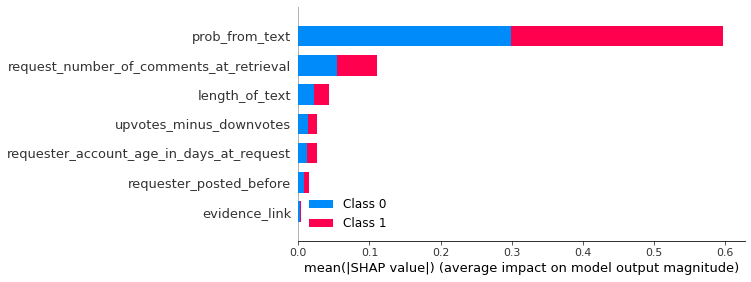

<Figure size 432x288 with 0 Axes>

In [22]:
# using shapley values to understand importance of each feature
count_explainer = shap.TreeExplainer(new_final_count_rf_model_rf)
count_shap_values = count_explainer.shap_values(X_test)
shap.summary_plot(count_shap_values, X_test, plot_type="bar")
plt.savefig('eps/FeatureImportanceShapley_count.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

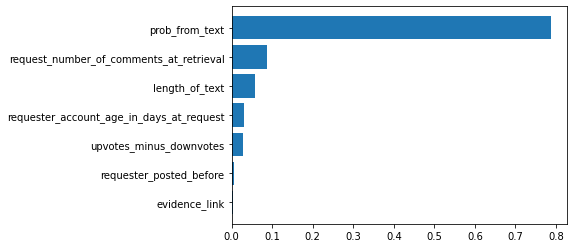

In [23]:
sorted_idx = new_final_count_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_count_rf_df.columns[sorted_idx], new_final_count_rf_model_rf.feature_importances_[sorted_idx])

In [24]:
test_count_df = new_count_vec.transform(test_set['final_request_text'])
print(test_count_df.shape)

(1134, 12667)


In [25]:
test_final_count_rf_df = final_test_set.copy()
test_count_rf_est_prob = new_count_model_rf.predict_proba(test_count_df)[:,1]
test_final_count_rf_df.insert(5,'prob_from_text',test_count_rf_est_prob)
test_final_count_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0.249434,0,1
1,1,0.000000,0,403,0,0.233747,0,0
2,3,1546.216493,4,527,0,0.234751,0,1
3,7,446.295185,2,710,0,0.359911,0,1
4,2,163.086551,3,771,0,0.302436,0,0
...,...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0.241736,0,0
1130,15,338.554259,0,383,0,0.156650,1,0
1131,1,184.172870,3,300,0,0.161837,1,1
1132,2,404.469190,0,366,0,0.181215,0,1


In [26]:
test_final_count_rf_df = test_final_count_rf_df.sample(frac=1).reset_index(drop=True)
test_final_count_rf_labels = test_final_count_rf_df.iloc[:,-1]
test_final_count_rf_df = test_final_count_rf_df.iloc[:,:-1]
test_final_count_rf_labels

0       0
1       0
2       0
3       0
4       0
       ..
1129    0
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [27]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df))],
    ['Random Forest', accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df)), f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.7107583774250441,0.4419889502762431,0.5594405594405595,0.49382716049382724
Gaussian NB,0.6984126984126984,0.4014084507042254,0.3986013986013986,0.4
Random Forest,0.7345679012345679,0.4672489082969432,0.3741258741258741,0.4155339805825243


## Random Forest based TF-IDF Model

In [28]:
new_tfidf_vec = TfidfVectorizer(analyzer=process_text)
new_tfidf_df = new_tfidf_vec.fit_transform(train_set['final_request_text'])

new_tfidf_labels = train_set['requester_received_pizza']

print(new_tfidf_df.shape)

(4537, 12667)


In [29]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_tfidf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_tfidf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_tfidf_model_nbg = GaussianNB()
new_tfidf_model_nbm = MultinomialNB()
new_tfidf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_tfidf_model_lr_accuracy_score = []
new_tfidf_model_nbg_accuracy_score = []
new_tfidf_model_nbm_accuracy_score = []
new_tfidf_model_rf_accuracy_score = []


for train_index, test_index in new_skfold_tfidf.split(new_tfidf_df, new_tfidf_labels):
    X_train, X_test = new_tfidf_df[train_index], new_tfidf_df[test_index]
    y_train, y_test = new_tfidf_labels[train_index], new_tfidf_labels[test_index]
    
    new_tfidf_model_lr.fit(X_train,y_train)
    new_tfidf_model_lr_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_lr.predict(X_test)))

    new_tfidf_model_nbg.fit(X_train.toarray(),y_train)
    new_tfidf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbg.predict(X_test.toarray())))
    
    new_tfidf_model_nbm.fit(X_train,y_train)
    new_tfidf_model_nbm_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_nbm.predict(X_test)))
    
    new_tfidf_model_rf.fit(X_train,y_train)
    new_tfidf_model_rf_accuracy_score.append(accuracy_score(y_test,new_tfidf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy']
new_t.add_rows([
    ['Logistic Regression', mean(new_tfidf_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_tfidf_model_nbg_accuracy_score)],
    ['Multinomial NB', mean(new_tfidf_model_nbm_accuracy_score)],
    ['Random Forest', mean(new_tfidf_model_rf_accuracy_score)],
])
new_t

Model,Accuracy
Logistic Regression,0.5622574904454882
Gaussian NB,0.5122244264861764
Multinomial NB,0.7551244274586457
Random Forest,0.7553446917758263


In [30]:
new_final_tfidf_rf_df = final_train_set.copy()
new_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(new_tfidf_df)[:,1]
new_final_tfidf_rf_df.insert(5,'prob_from_text',new_tfidf_rf_est_prob)
new_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,2,125.174259,6,247,1,0.449429,1,1
1,3,862.983495,1,432,0,0.588775,0,1
2,3,101.920671,0,238,0,0.180611,1,0
3,3,159.823935,7,337,0,0.452456,1,1
4,1,80.338808,5,417,0,0.174887,0,0
...,...,...,...,...,...,...,...,...
4532,21,32.851157,13,665,0,0.727147,0,1
4533,2,379.848507,0,405,0,0.152880,0,0
4534,1,125.273750,0,667,0,0.164605,0,0
4535,1,29.702674,0,200,0,0.140744,0,0


In [31]:
new_final_tfidf_rf_df = new_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
new_final_tfidf_rf_labels = new_final_tfidf_rf_df.iloc[:,-1]
new_final_tfidf_rf_df = new_final_tfidf_rf_df.iloc[:,:-1]
new_final_tfidf_rf_labels

0       0
1       0
2       0
3       0
4       0
       ..
4532    1
4533    0
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [32]:
new_skfold_final_tfidf_rf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_final_tfidf_rf_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_tfidf_rf_model_nbg = GaussianNB()
new_final_tfidf_rf_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_tfidf_rf_model_lr_accuracy_score = []
new_final_tfidf_rf_model_nbg_accuracy_score = []
new_final_tfidf_rf_model_rf_accuracy_score = []

new_final_tfidf_rf_model_lr_precision_score = []
new_final_tfidf_rf_model_nbg_precision_score = []
new_final_tfidf_rf_model_rf_precision_score = []

new_final_tfidf_rf_model_lr_recall_score = []
new_final_tfidf_rf_model_nbg_recall_score = []
new_final_tfidf_rf_model_rf_recall_score = []

new_final_tfidf_rf_model_lr_f1_score = []
new_final_tfidf_rf_model_nbg_f1_score = []
new_final_tfidf_rf_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_tfidf_rf.split(new_final_tfidf_rf_df, new_final_tfidf_rf_labels):
    X_train, X_test = new_final_tfidf_rf_df.iloc[train_index,:], new_final_tfidf_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_tfidf_rf_labels[train_index], new_final_tfidf_rf_labels[test_index]
    
    new_final_tfidf_rf_model_lr.fit(X_train,y_train)
    new_final_tfidf_rf_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    new_final_tfidf_rf_model_lr_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_lr.predict(X_test)))
    
    new_final_tfidf_rf_model_nbg.fit(X_train,y_train)
    new_final_tfidf_rf_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    new_final_tfidf_rf_model_nbg_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_nbg.predict(X_test)))
    
    new_final_tfidf_rf_model_rf.fit(X_train,y_train)
    new_final_tfidf_rf_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_precision_score.append(precision_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_recall_score.append(recall_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))
    new_final_tfidf_rf_model_rf_f1_score.append(f1_score(y_test,new_final_tfidf_rf_model_rf.predict(X_test)))

new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', mean(new_final_tfidf_rf_model_lr_accuracy_score),mean(new_final_tfidf_rf_model_lr_precision_score),mean(new_final_tfidf_rf_model_lr_recall_score),mean(new_final_tfidf_rf_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_tfidf_rf_model_nbg_accuracy_score),mean(new_final_tfidf_rf_model_nbg_precision_score),mean(new_final_tfidf_rf_model_nbg_recall_score),mean(new_final_tfidf_rf_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_tfidf_rf_model_rf_accuracy_score),mean(new_final_tfidf_rf_model_rf_precision_score),mean(new_final_tfidf_rf_model_rf_recall_score),mean(new_final_tfidf_rf_model_rf_f1_score)],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9545910279973937,0.8843437814309552,0.9406129343629344,0.9107355033460559
Gaussian NB,0.9545997802219175,0.8918030945070461,0.9280164092664093,0.9092546783346785
Random Forest,0.9750970038218048,0.9692630665979722,0.9280164092664093,0.9479308749039995


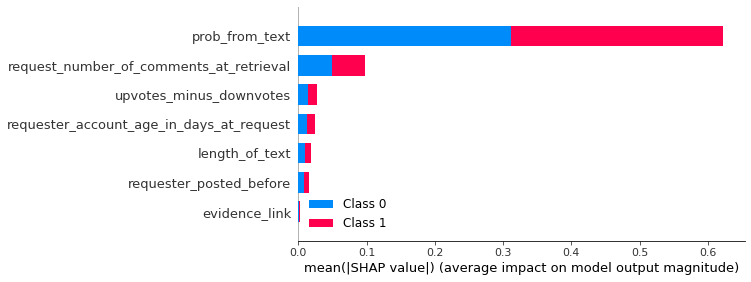

<Figure size 432x288 with 0 Axes>

In [33]:
# using shapley values to understand importance of each feature
tfidf_explainer = shap.TreeExplainer(new_final_tfidf_rf_model_rf)
tfidf_shap_values = tfidf_explainer.shap_values(X_test)
shap.summary_plot(tfidf_shap_values, X_test, plot_type="bar")
plt.savefig('eps/FeatureImportanceShapley_rf.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

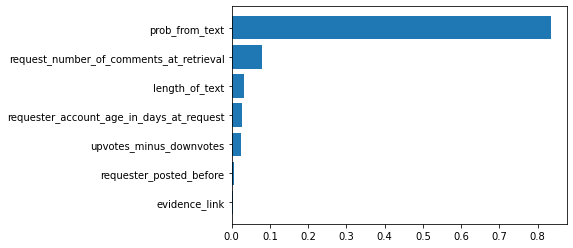

In [34]:
sorted_idx = new_final_tfidf_rf_model_rf.feature_importances_.argsort()
plt.barh(new_final_tfidf_rf_df.columns[sorted_idx], new_final_tfidf_rf_model_rf.feature_importances_[sorted_idx])

In [35]:
test_tfidf_df = new_tfidf_vec.transform(test_set['final_request_text'])
print(test_tfidf_df.shape)

(1134, 12667)


In [36]:
final_test_set

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0,1
1,1,0.000000,0,403,0,0,0
2,3,1546.216493,4,527,0,0,1
3,7,446.295185,2,710,0,0,1
4,2,163.086551,3,771,0,0,0
...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0,0
1130,15,338.554259,0,383,0,1,0
1131,1,184.172870,3,300,0,1,1
1132,2,404.469190,0,366,0,0,1


In [37]:
test_final_tfidf_rf_df = final_test_set.copy()
test_tfidf_rf_est_prob = new_tfidf_model_rf.predict_proba(test_tfidf_df)[:,1]
test_final_tfidf_rf_df.insert(5,'prob_from_text',test_tfidf_rf_est_prob)
test_final_tfidf_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0.224852,0,1
1,1,0.000000,0,403,0,0.257468,0,0
2,3,1546.216493,4,527,0,0.260642,0,1
3,7,446.295185,2,710,0,0.349723,0,1
4,2,163.086551,3,771,0,0.282305,0,0
...,...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0.279182,0,0
1130,15,338.554259,0,383,0,0.161640,1,0
1131,1,184.172870,3,300,0,0.177356,1,1
1132,2,404.469190,0,366,0,0.220201,0,1


In [38]:
test_final_tfidf_rf_df = test_final_tfidf_rf_df.sample(frac=1).reset_index(drop=True)
test_final_tfidf_rf_labels = test_final_tfidf_rf_df.iloc[:,-1]
test_final_tfidf_rf_df = test_final_tfidf_rf_df.iloc[:,:-1]
test_final_tfidf_rf_labels

0       0
1       1
2       0
3       1
4       1
       ..
1129    0
1130    0
1131    0
1132    0
1133    1
Name: requester_received_pizza, Length: 1134, dtype: int64

In [39]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df))],
    ['Random Forest', accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df)), f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6657848324514991,0.3863080684596577,0.5524475524475524,0.4546762589928057
Gaussian NB,0.671957671957672,0.3735294117647059,0.44405594405594406,0.4057507987220447
Random Forest,0.7486772486772487,0.5028248587570622,0.3111888111888112,0.3844492440604752


## Random Forest based MinMax Word2Vec Model

In [40]:
model = KeyedVectors.load_word2vec_format(PATH + "GoogleNews-vectors-negative300.bin", limit = 10**6,binary=True)

def get_vec(word):
    try:
        return model[word]
    except:
        return np.zeros(300)

def get_sent_vec_min_max(sent):
    tokens = process_text(sent)
    min_vector = np.min([get_vec(t) for t in tokens], axis = 0)
    max_vector = np.max([get_vec(t) for t in tokens], axis = 0)
    vector = np.concatenate([min_vector,max_vector])
    
    return vector

new_minmax_word2vec_emb = train_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
new_minmax_v = np.column_stack([new_minmax_word2vec_emb.values.tolist()])
new_minmax_word2vec_df = pd.DataFrame(new_minmax_v)
new_minmax_word2vec_labels = train_set['requester_received_pizza']
new_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.326172,-0.279297,-0.376953,-0.138672,-0.259766,-0.196289,-0.250000,-0.199219,-0.135742,-0.371094,...,0.265625,0.371094,0.208984,0.353516,0.546875,0.335938,0.184570,0.159180,0.294922,0.320312
1,-0.416016,-0.129883,-0.371094,-0.129883,-0.249023,-0.227539,-0.261719,-0.367188,-0.402344,-0.151367,...,0.306641,0.298828,0.251953,0.398438,0.671875,0.300781,0.333984,0.304688,0.251953,0.468750
2,-0.367188,-0.343750,-0.294922,-0.265625,-0.277344,-0.248047,-0.205078,-0.773438,-0.125977,-0.267578,...,0.263672,0.182617,0.199219,0.353516,0.546875,0.320312,0.147461,0.208008,0.498047,0.204102
3,-0.178711,-0.406250,-0.294922,-0.279297,-0.380859,-0.347656,-0.231445,-0.289062,-0.386719,-0.484375,...,0.227539,0.404297,0.219727,0.316406,0.298828,0.277344,0.287109,0.213867,0.238281,0.192383
4,-0.228516,-0.291016,-0.439453,-0.251953,-0.253906,-0.283203,-0.378906,-0.414062,-0.172852,-0.240234,...,0.109863,0.298828,0.219727,0.398438,0.546875,0.277344,0.281250,0.416016,0.197266,0.292969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4532,-0.388672,-0.275391,-0.302734,-0.214844,-0.515625,-0.347656,-0.382812,-0.351562,-0.172852,-0.267578,...,0.365234,0.376953,0.124023,0.398438,0.281250,0.277344,0.353516,0.357422,0.229492,0.281250
4533,-0.207031,-0.291016,-0.416016,-0.287109,-0.238281,-0.460938,-0.462891,-0.396484,-0.373047,-0.240234,...,0.265625,0.445312,0.148438,0.398438,0.546875,0.277344,0.281250,0.404297,0.302734,0.373047
4534,-0.416016,-0.233398,-0.226562,-0.238281,-0.261719,-0.318359,-0.267578,-0.414062,-0.167969,-0.376953,...,0.365234,0.425781,0.219727,0.257812,0.671875,0.195312,0.253906,0.265625,0.259766,0.271484
4535,-0.225586,-0.291016,-0.332031,-0.062988,-0.222656,-0.314453,-0.224609,-0.367188,-0.402344,-0.227539,...,0.044678,0.184570,0.101074,0.398438,0.546875,0.108887,0.182617,0.215820,0.347656,0.231445


In [42]:
# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_minmax_word2vec = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_minmax_word2vec_model_nbg = GaussianNB()
new_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_minmax_word2vec_model_lr_accuracy_score = []
new_minmax_word2vec_model_nbg_accuracy_score = []
new_minmax_word2vec_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_minmax_word2vec.split(new_minmax_word2vec_df, new_minmax_word2vec_labels):
    X_train, X_test = new_minmax_word2vec_df.iloc[train_index,:], new_minmax_word2vec_df.iloc[test_index,:]
    y_train, y_test = new_minmax_word2vec_labels[train_index], new_minmax_word2vec_labels[test_index]
    
    new_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_lr.predict(X_test)))
    
    new_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_minmax_word2vec_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_minmax_word2vec_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_minmax_word2vec_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.5157681049488967
Gaussian NB,0.574157112154895
Random Forest,0.7549041631414651


In [43]:
new_final_minmax_word2vec_rf_df = final_train_set.copy()
new_minmax_word2vec_rf_est_prob = new_minmax_word2vec_model_rf.predict_proba(new_minmax_word2vec_df)[:,1]
new_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',new_minmax_word2vec_rf_est_prob)

In [44]:
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
new_final_minmax_word2vec_rf_labels = new_final_minmax_word2vec_rf_df.iloc[:,-1]
new_final_minmax_word2vec_rf_df = new_final_minmax_word2vec_rf_df.iloc[:,:-1]
new_final_minmax_word2vec_rf_labels

0       0
1       1
2       0
3       1
4       0
       ..
4532    0
4533    0
4534    0
4535    0
4536    1
Name: requester_received_pizza, Length: 4537, dtype: int64

In [45]:
new_skfold_final_minmax_word2vec = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_final_minmax_word2vec_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_minmax_word2vec_model_nbg = GaussianNB()
new_final_minmax_word2vec_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_minmax_word2vec_model_lr_accuracy_score = []
new_final_minmax_word2vec_model_nbg_accuracy_score = []
new_final_minmax_word2vec_model_rf_accuracy_score = []

new_final_minmax_word2vec_model_lr_precision_score = []
new_final_minmax_word2vec_model_nbg_precision_score = []
new_final_minmax_word2vec_model_rf_precision_score = []

new_final_minmax_word2vec_model_lr_recall_score = []
new_final_minmax_word2vec_model_nbg_recall_score = []
new_final_minmax_word2vec_model_rf_recall_score = []

new_final_minmax_word2vec_model_lr_f1_score = []
new_final_minmax_word2vec_model_nbg_f1_score = []
new_final_minmax_word2vec_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_minmax_word2vec.split(new_final_minmax_word2vec_rf_df, new_final_minmax_word2vec_rf_labels):
    X_train, X_test = new_final_minmax_word2vec_rf_df.iloc[train_index,:], new_final_minmax_word2vec_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_minmax_word2vec_rf_labels[train_index], new_final_minmax_word2vec_rf_labels[test_index]
    
    new_final_minmax_word2vec_model_lr.fit(X_train,y_train)
    new_final_minmax_word2vec_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    new_final_minmax_word2vec_model_lr_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_lr.predict(X_test)))
    
    new_final_minmax_word2vec_model_nbg.fit(X_train,y_train)
    new_final_minmax_word2vec_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    new_final_minmax_word2vec_model_nbg_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_nbg.predict(X_test)))
    
    new_final_minmax_word2vec_model_rf.fit(X_train,y_train)
    new_final_minmax_word2vec_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_precision_score.append(precision_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_recall_score.append(recall_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))
    new_final_minmax_word2vec_model_rf_f1_score.append(f1_score(y_test,new_final_minmax_word2vec_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_minmax_word2vec_model_lr_accuracy_score),mean(new_final_minmax_word2vec_model_lr_precision_score),mean(new_final_minmax_word2vec_model_lr_recall_score),mean(new_final_minmax_word2vec_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_minmax_word2vec_model_nbg_accuracy_score),mean(new_final_minmax_word2vec_model_nbg_precision_score),mean(new_final_minmax_word2vec_model_nbg_recall_score),mean(new_final_minmax_word2vec_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_minmax_word2vec_model_rf_accuracy_score),mean(new_final_minmax_word2vec_model_rf_precision_score),mean(new_final_minmax_word2vec_model_rf_recall_score),mean(new_final_minmax_word2vec_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9656163997238187,0.9020432031884137,0.9648889961389961,0.9322443764787138
Gaussian NB,0.9684803220818625,0.9259430470772495,0.9477879665379665,0.9365019874342791
Random Forest,0.9783975649366436,0.9733162832026095,0.9378780566280567,0.9550948254436454


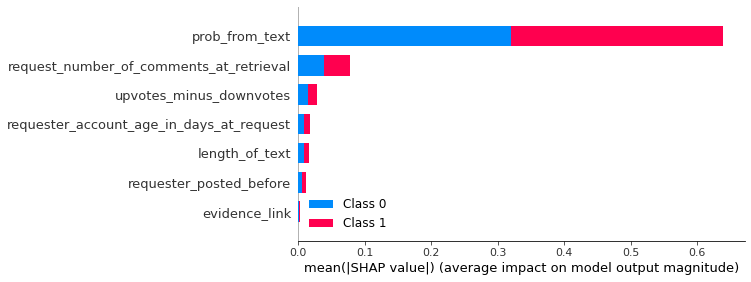

In [46]:
# using shapley values to understand importance of each feature
minmax_word2vec_explainer = shap.TreeExplainer(new_final_minmax_word2vec_model_rf)
minmax_word2vec_shap_values = minmax_word2vec_explainer.shap_values(X_test)
shap.summary_plot(minmax_word2vec_shap_values, X_test, plot_type="bar",show=False)
plt.savefig('eps/FeatureImportanceShapley_minmax.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

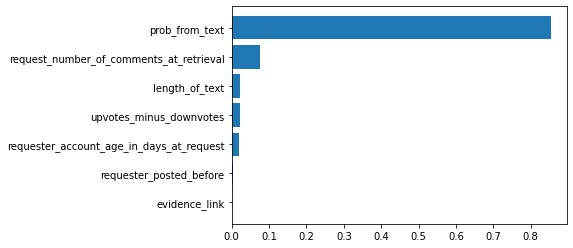

In [47]:
sorted_idx = new_final_minmax_word2vec_model_rf.feature_importances_.argsort()
plt.barh(new_final_minmax_word2vec_rf_df.columns[sorted_idx], new_final_minmax_word2vec_model_rf.feature_importances_[sorted_idx])

In [48]:
test_minmax_word2vec_emb = test_set.apply(lambda r: get_sent_vec_min_max(r['final_request_text']), axis=1)
test_minmax_v = np.column_stack([test_minmax_word2vec_emb.values.tolist()])
test_minmax_word2vec_df = pd.DataFrame(test_minmax_v)
test_minmax_word2vec_labels = test_set['requester_received_pizza']
test_minmax_word2vec_df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,-0.257812,-0.300781,-0.402344,-0.197266,-0.468750,-0.361328,-0.259766,-0.308594,-0.296875,-0.267578,...,0.207031,0.294922,0.215820,0.398438,0.546875,0.277344,0.281250,0.241211,0.294922,0.468750
1,-0.247070,-0.244141,-0.294922,-0.122070,-0.306641,-0.201172,-0.171875,-0.380859,-0.357422,-0.152344,...,0.308594,0.470703,0.229492,0.215820,0.546875,0.255859,0.185547,0.245117,0.294922,0.217773
2,-0.181641,-0.168945,-0.398438,-0.384766,-0.343750,-0.326172,-0.253906,-0.335938,-0.172852,-0.267578,...,0.202148,0.425781,0.181641,0.398438,0.546875,0.267578,0.265625,0.217773,0.207031,0.082031
3,-0.226562,-0.247070,-0.398438,-0.238281,-0.306641,-0.439453,-0.241211,-0.333984,-0.322266,-0.376953,...,0.257812,0.419922,0.314453,0.351562,0.546875,0.361328,0.472656,0.292969,0.294922,0.141602
4,-0.318359,-0.236328,-0.326172,-0.229492,-0.308594,-0.237305,-0.202148,-0.335938,-0.159180,-0.375000,...,0.296875,0.269531,0.127930,0.394531,0.546875,0.398438,0.273438,0.376953,0.289062,0.240234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,-0.302734,-0.194336,-0.294922,-0.304688,-0.421875,-0.166992,-0.217773,-0.225586,-0.243164,-0.375000,...,0.277344,0.312500,0.163086,0.410156,0.546875,0.271484,0.209961,0.207031,0.443359,0.137695
1130,-0.247070,-0.213867,-0.294922,-0.279297,-0.208984,-0.294922,-0.174805,-0.330078,-0.249023,-0.209961,...,0.306641,0.414062,0.058838,0.398438,0.546875,0.187500,0.175781,0.314453,0.292969,0.158203
1131,-0.247070,-0.275391,-0.371094,-0.149414,-0.279297,-0.347656,-0.375000,-0.265625,-0.189453,-0.116211,...,0.167969,0.269531,0.159180,0.398438,0.546875,0.187500,0.304688,0.159180,0.182617,0.178711
1132,-0.388672,-0.153320,-0.294922,-0.182617,-0.210938,-0.221680,-0.141602,-0.263672,-0.172852,-0.234375,...,0.231445,0.279297,0.143555,0.398438,0.546875,0.187500,0.137695,0.159180,0.242188,0.211914


In [49]:
test_final_minmax_word2vec_rf_df = final_test_set.copy()
test_tfidf_minmax_word2vec_est_prob = new_minmax_word2vec_model_rf.predict_proba(test_minmax_word2vec_df)[:,1]
test_final_minmax_word2vec_rf_df.insert(5,'prob_from_text',test_tfidf_minmax_word2vec_est_prob)
test_final_minmax_word2vec_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0.258757,0,1
1,1,0.000000,0,403,0,0.234181,0,0
2,3,1546.216493,4,527,0,0.279379,0,1
3,7,446.295185,2,710,0,0.322316,0,1
4,2,163.086551,3,771,0,0.274011,0,0
...,...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0.262429,0,0
1130,15,338.554259,0,383,0,0.220339,1,0
1131,1,184.172870,3,300,0,0.196045,1,1
1132,2,404.469190,0,366,0,0.178249,0,1


In [50]:
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.sample(frac=1).reset_index(drop=True)
test_final_minmax_word2vec_rf_labels = test_final_minmax_word2vec_rf_df.iloc[:,-1]
test_final_minmax_word2vec_rf_df = test_final_minmax_word2vec_rf_df.iloc[:,:-1]
test_final_minmax_word2vec_rf_labels

0       1
1       1
2       0
3       0
4       0
       ..
1129    0
1130    1
1131    0
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [51]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df))],
    ['Random Forest', accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df)), f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.6437389770723104,0.3665158371040724,0.5664335664335665,0.44505494505494503
Gaussian NB,0.6851851851851852,0.3745583038869258,0.3706293706293706,0.37258347978910367
Random Forest,0.7548500881834215,0.5229885057471264,0.3181818181818182,0.3956521739130435


## Random Forest based Doc2Vec 100 Model

In [53]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_100_model = Doc2Vec(vector_size=100, min_count=2, epochs = 50)

new_doc2vec_100_model.build_vocab(new_tagged_data)
new_doc2vec_100_model.train(new_tagged_data, epochs=new_doc2vec_100_model.epochs, total_examples=new_doc2vec_100_model.corpus_count)

new_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_100_df = pd.DataFrame(new_doc2vec_100_v)
new_doc2vec_100_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_100 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_doc2vec_100_model_nbg = GaussianNB()
new_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_doc2vec_100_model_lr_accuracy_score = []
new_doc2vec_100_model_nbg_accuracy_score = []
new_doc2vec_100_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_100.split(new_doc2vec_100_df, new_doc2vec_100_labels):
    X_train, X_test = new_doc2vec_100_df.iloc[train_index,:], new_doc2vec_100_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_100_labels[train_index], new_doc2vec_100_labels[test_index]
    
    new_doc2vec_100_model_lr.fit(X_train,y_train)
    new_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_lr.predict(X_test)))
    
    new_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_nbg.predict(X_test)))
    
    new_doc2vec_100_model_rf.fit(X_train,y_train)
    new_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_100_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_100_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_100_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.38064396923106847
Gaussian NB,0.6590288920656222
Random Forest,0.7535825772383814


In [54]:
new_final_doc2vec_100_rf_df = final_train_set.copy()
new_doc2vec_100_rf_est_prob = new_doc2vec_100_model_rf.predict_proba(new_doc2vec_100_df)[:,1]
new_final_doc2vec_100_rf_df.insert(5,'prob_from_text',new_doc2vec_100_rf_est_prob)

In [55]:
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_100_rf_labels = new_final_doc2vec_100_rf_df.iloc[:,-1]
new_final_doc2vec_100_rf_df = new_final_doc2vec_100_rf_df.iloc[:,:-1]
new_final_doc2vec_100_rf_labels

0       0
1       1
2       0
3       1
4       0
       ..
4532    0
4533    1
4534    0
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [56]:
new_skfold_final_doc2vec_100 = StratifiedKFold(n_splits = 10,shuffle=True, random_state=RANDOM_STATE)
new_final_doc2vec_100_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_doc2vec_100_model_nbg = GaussianNB()
new_final_doc2vec_100_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_doc2vec_100_model_lr_accuracy_score = []
new_final_doc2vec_100_model_nbg_accuracy_score = []
new_final_doc2vec_100_model_rf_accuracy_score = []

new_final_doc2vec_100_model_lr_precision_score = []
new_final_doc2vec_100_model_nbg_precision_score = []
new_final_doc2vec_100_model_rf_precision_score = []

new_final_doc2vec_100_model_lr_recall_score = []
new_final_doc2vec_100_model_nbg_recall_score = []
new_final_doc2vec_100_model_rf_recall_score = []

new_final_doc2vec_100_model_lr_f1_score = []
new_final_doc2vec_100_model_nbg_f1_score = []
new_final_doc2vec_100_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_100.split(new_final_doc2vec_100_rf_df, new_final_doc2vec_100_rf_labels):
    X_train, X_test = new_final_doc2vec_100_rf_df.iloc[train_index,:], new_final_doc2vec_100_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_100_rf_labels[train_index], new_final_doc2vec_100_rf_labels[test_index]
    
    new_final_doc2vec_100_model_lr.fit(X_train,y_train)
    new_final_doc2vec_100_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    new_final_doc2vec_100_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_lr.predict(X_test)))
    
    new_final_doc2vec_100_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_100_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))
    new_final_doc2vec_100_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_nbg.predict(X_test)))

    new_final_doc2vec_100_model_rf.fit(X_train,y_train)
    new_final_doc2vec_100_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))
    new_final_doc2vec_100_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_100_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_100_model_lr_accuracy_score),mean(new_final_doc2vec_100_model_lr_precision_score),mean(new_final_doc2vec_100_model_lr_recall_score),mean(new_final_doc2vec_100_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_100_model_nbg_accuracy_score),mean(new_final_doc2vec_100_model_nbg_precision_score),mean(new_final_doc2vec_100_model_nbg_recall_score),mean(new_final_doc2vec_100_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_100_model_rf_accuracy_score),mean(new_final_doc2vec_100_model_rf_precision_score),mean(new_final_doc2vec_100_model_rf_recall_score),mean(new_final_doc2vec_100_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.96649988816602,0.905565748144047,0.9648970398970399,0.9340158840939113
Gaussian NB,0.9640760082076416,0.9129693818986342,0.9442165379665379,0.9280260796623333
Random Forest,0.9795052075735916,0.9732301051870033,0.9424227799227799,0.9574585268420975


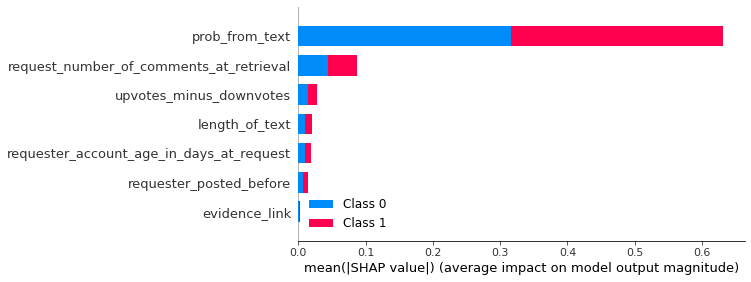

<Figure size 432x288 with 0 Axes>

In [57]:
# using shapley values to understand importance of each feature
doc2vec_100_explainer = shap.TreeExplainer(new_final_doc2vec_100_model_rf)
doc2vec_100_shap_values = doc2vec_100_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_100_shap_values, X_test, plot_type="bar")
plt.savefig('eps/FeatureImportanceShapley_doc2vec_100.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

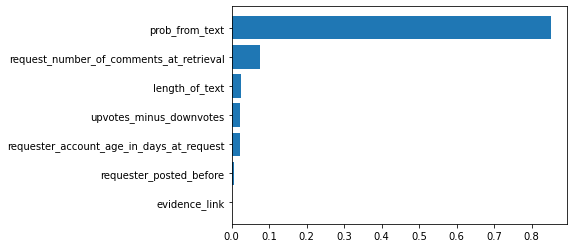

In [58]:
sorted_idx = new_final_doc2vec_100_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_100_rf_df.columns[sorted_idx], new_final_doc2vec_100_model_rf.feature_importances_[sorted_idx])

In [59]:
test_doc2vec_100_v = np.row_stack([new_doc2vec_100_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_100_df = pd.DataFrame(test_doc2vec_100_v)

In [60]:
test_final_doc2vec_100_rf_df = final_test_set.copy()
test_tfidf_doc2vec_100_est_prob = new_doc2vec_100_model_rf.predict_proba(test_doc2vec_100_df)[:,1]
test_final_doc2vec_100_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_100_est_prob)
test_final_doc2vec_100_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0.417232,0,1
1,1,0.000000,0,403,0,0.294350,0,0
2,3,1546.216493,4,527,0,0.385876,0,1
3,7,446.295185,2,710,0,0.411864,0,1
4,2,163.086551,3,771,0,0.411864,0,0
...,...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0.319492,0,0
1130,15,338.554259,0,383,0,0.399718,1,0
1131,1,184.172870,3,300,0,0.395198,1,1
1132,2,404.469190,0,366,0,0.307062,0,1


In [61]:
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_100_rf_labels = test_final_doc2vec_100_rf_df.iloc[:,-1]
test_final_doc2vec_100_rf_df = test_final_doc2vec_100_rf_df.iloc[:,:-1]
test_final_doc2vec_100_rf_labels

0       1
1       0
2       0
3       0
4       0
       ..
1129    1
1130    0
1131    1
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [62]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df)), f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.4470899470899471,0.29482551143200963,0.8566433566433567,0.43867502238137873
Gaussian NB,0.5326278659611993,0.30130293159609123,0.6468531468531469,0.41111111111111115
Random Forest,0.7495590828924162,0.5051020408163265,0.34615384615384615,0.4107883817427385


## Random Forest based Doc2Vec 300 Model

In [63]:
new_tagged_data = [TaggedDocument(words=process_text(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train_set['final_request_text'])]

new_doc2vec_300_model = Doc2Vec(vector_size=300, min_count=2, epochs = 50)

new_doc2vec_300_model.build_vocab(new_tagged_data)
new_doc2vec_300_model.train(new_tagged_data, epochs=new_doc2vec_300_model.epochs, total_examples=new_doc2vec_300_model.corpus_count)

new_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(train_set['final_request_text'][x])) for x in range(len(train_set))])
new_doc2vec_300_df = pd.DataFrame(new_doc2vec_300_v)
new_doc2vec_300_labels = train_set['requester_received_pizza']

# MODELING TO GET ESTIMATES AND USING 
# STRATIFIED CROSS-VALIDATION AS THE DATASET IS IMBALANCED

new_skfold_doc2vec_300 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_doc2vec_300_model_nbg = GaussianNB()
new_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_doc2vec_300_model_lr_accuracy_score = []
new_doc2vec_300_model_nbg_accuracy_score = []
new_doc2vec_300_model_rf_accuracy_score = []

for train_index, test_index in new_skfold_doc2vec_300.split(new_doc2vec_300_df, new_doc2vec_300_labels):
    X_train, X_test = new_doc2vec_300_df.iloc[train_index,:], new_doc2vec_300_df.iloc[test_index,:]
    y_train, y_test = new_doc2vec_300_labels[train_index], new_doc2vec_300_labels[test_index]
    
    new_doc2vec_300_model_lr.fit(X_train,y_train)
    new_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_lr.predict(X_test)))
    
    new_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_nbg.predict(X_test)))
    
    new_doc2vec_300_model_rf.fit(X_train,y_train)
    new_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy']
t.add_rows([
    ['Logistic Regression', mean(new_doc2vec_300_model_lr_accuracy_score)],
    ['Gaussian NB', mean(new_doc2vec_300_model_nbg_accuracy_score)],
    ['Random Forest', mean(new_doc2vec_300_model_rf_accuracy_score)]
])
t

Model,Accuracy
Logistic Regression,0.4566891307096109
Gaussian NB,0.6444758876214371
Random Forest,0.7540226196380468


In [64]:
new_final_doc2vec_300_rf_df = final_train_set.copy()
new_doc2vec_300_rf_est_prob = new_doc2vec_300_model_rf.predict_proba(new_doc2vec_300_df)[:,1]
new_final_doc2vec_300_rf_df.insert(5,'prob_from_text',new_doc2vec_300_rf_est_prob)

In [65]:
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
new_final_doc2vec_300_rf_labels = new_final_doc2vec_300_rf_df.iloc[:,-1]
new_final_doc2vec_300_rf_df = new_final_doc2vec_300_rf_df.iloc[:,:-1]
new_final_doc2vec_300_rf_labels

0       0
1       0
2       0
3       0
4       0
       ..
4532    0
4533    0
4534    1
4535    0
4536    0
Name: requester_received_pizza, Length: 4537, dtype: int64

In [66]:
new_skfold_final_doc2vec_300 = StratifiedKFold(n_splits = 10, shuffle=True, random_state=RANDOM_STATE)
new_final_doc2vec_300_model_lr = LogisticRegression(class_weight = {0:1, 1:5}, random_state=RANDOM_STATE)
new_final_doc2vec_300_model_nbg = GaussianNB()
new_final_doc2vec_300_model_rf = RandomForestClassifier(n_estimators=590, min_samples_leaf=2, min_samples_split=2, max_features='sqrt',max_depth=50, bootstrap=False, random_state=RANDOM_STATE)

new_final_doc2vec_300_model_lr_accuracy_score = []
new_final_doc2vec_300_model_nbg_accuracy_score = []
new_final_doc2vec_300_model_rf_accuracy_score = []

new_final_doc2vec_300_model_lr_precision_score = []
new_final_doc2vec_300_model_nbg_precision_score = []
new_final_doc2vec_300_model_rf_precision_score = []

new_final_doc2vec_300_model_lr_recall_score = []
new_final_doc2vec_300_model_nbg_recall_score = []
new_final_doc2vec_300_model_rf_recall_score = []

new_final_doc2vec_300_model_lr_f1_score = []
new_final_doc2vec_300_model_nbg_f1_score = []
new_final_doc2vec_300_model_rf_f1_score = []


for train_index, test_index in new_skfold_final_doc2vec_300.split(new_final_doc2vec_300_rf_df, new_final_doc2vec_300_rf_labels):
    X_train, X_test = new_final_doc2vec_300_rf_df.iloc[train_index,:], new_final_doc2vec_300_rf_df.iloc[test_index,:]
    y_train, y_test = new_final_doc2vec_300_rf_labels[train_index], new_final_doc2vec_300_rf_labels[test_index]
    
    new_final_doc2vec_300_model_lr.fit(X_train,y_train)
    new_final_doc2vec_300_model_lr_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    new_final_doc2vec_300_model_lr_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_lr.predict(X_test)))
    
    new_final_doc2vec_300_model_nbg.fit(X_train,y_train)
    new_final_doc2vec_300_model_nbg_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))
    new_final_doc2vec_300_model_nbg_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_nbg.predict(X_test)))

    new_final_doc2vec_300_model_rf.fit(X_train,y_train)
    new_final_doc2vec_300_model_rf_accuracy_score.append(accuracy_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_precision_score.append(precision_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_recall_score.append(recall_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))
    new_final_doc2vec_300_model_rf_f1_score.append(f1_score(y_test,new_final_doc2vec_300_model_rf.predict(X_test)))

t = PrettyTable()
t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
t.add_rows([
    ['Logistic Regression', mean(new_final_doc2vec_300_model_lr_accuracy_score),mean(new_final_doc2vec_300_model_lr_precision_score),mean(new_final_doc2vec_300_model_lr_recall_score),mean(new_final_doc2vec_300_model_lr_f1_score)],
    ['Gaussian NB', mean(new_final_doc2vec_300_model_nbg_accuracy_score),mean(new_final_doc2vec_300_model_nbg_precision_score),mean(new_final_doc2vec_300_model_nbg_recall_score),mean(new_final_doc2vec_300_model_nbg_f1_score)],
    ['Random Forest', mean(new_final_doc2vec_300_model_rf_accuracy_score),mean(new_final_doc2vec_300_model_rf_precision_score),mean(new_final_doc2vec_300_model_rf_recall_score),mean(new_final_doc2vec_300_model_rf_f1_score)],
])
t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.9640735770341629,0.8979741341992823,0.9630871943371944,0.9292576288322528
Gaussian NB,0.9640735770341629,0.9125727864756984,0.9441843629343629,0.9279160280625108
Random Forest,0.9779560638328909,0.9722253042843647,0.9369771557271558,0.954040170016052


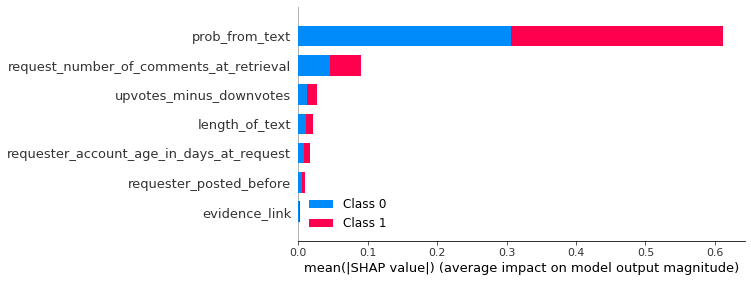

<Figure size 432x288 with 0 Axes>

In [67]:
# using shapley values to understand importance of each feature
doc2vec_300_explainer = shap.TreeExplainer(new_final_doc2vec_300_model_rf)
doc2vec_300_shap_values = doc2vec_300_explainer.shap_values(X_test)
shap.summary_plot(doc2vec_300_shap_values, X_test, plot_type="bar")
plt.savefig('eps/FeatureImportanceShapley_doc2vec_300.eps',dpi=1200,bbox_inches='tight')

<BarContainer object of 7 artists>

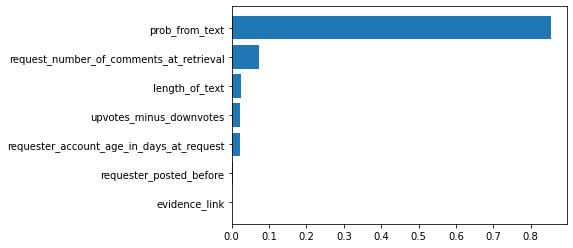

In [68]:
sorted_idx = new_final_doc2vec_300_model_rf.feature_importances_.argsort()
plt.barh(new_final_doc2vec_300_rf_df.columns[sorted_idx], new_final_doc2vec_300_model_rf.feature_importances_[sorted_idx])

In [69]:
test_doc2vec_300_v = np.row_stack([new_doc2vec_300_model.infer_vector(process_text(test_set['final_request_text'][x])) for x in range(len(test_set))])
test_doc2vec_300_df = pd.DataFrame(test_doc2vec_300_v)

In [70]:
test_final_doc2vec_300_rf_df = final_test_set.copy()
test_tfidf_doc2vec_300_est_prob = new_doc2vec_300_model_rf.predict_proba(test_doc2vec_300_df)[:,1]
test_final_doc2vec_300_rf_df.insert(5,'prob_from_text',test_tfidf_doc2vec_300_est_prob)
test_final_doc2vec_300_rf_df

,upvotes_minus_downvotes,requester_account_age_in_days_at_request,request_number_of_comments_at_retrieval,length_of_text,evidence_link,prob_from_text,requester_posted_before,requester_received_pizza
0,17,60.910324,50,747,0,0.449153,0,1
1,1,0.000000,0,403,0,0.367797,0,0
2,3,1546.216493,4,527,0,0.455650,0,1
3,7,446.295185,2,710,0,0.455085,0,1
4,2,163.086551,3,771,0,0.453107,0,0
...,...,...,...,...,...,...,...,...
1129,6,212.977292,4,456,0,0.385593,0,0
1130,15,338.554259,0,383,0,0.410169,1,0
1131,1,184.172870,3,300,0,0.361864,1,1
1132,2,404.469190,0,366,0,0.242655,0,1


In [71]:
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.sample(frac=1).reset_index(drop=True)
test_final_doc2vec_300_rf_labels = test_final_doc2vec_300_rf_df.iloc[:,-1]
test_final_doc2vec_300_rf_df = test_final_doc2vec_300_rf_df.iloc[:,:-1]
test_final_doc2vec_300_rf_labels

0       0
1       1
2       0
3       1
4       1
       ..
1129    1
1130    0
1131    0
1132    0
1133    0
Name: requester_received_pizza, Length: 1134, dtype: int64

In [72]:
new_t = PrettyTable()
new_t.field_names = ['Model','Accuracy','Precision','Recall','F1-Score']
new_t.add_rows([
    ['Logistic Regression', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df))],
    ['Gaussian NB', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df))],
    ['Random Forest', accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df)), f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))],
])
new_t

Model,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.4409171075837742,0.29236276849642007,0.8566433566433567,0.4359430604982206
Gaussian NB,0.5035273368606702,0.293591654247392,0.6888111888111889,0.41170323928944624
Random Forest,0.7583774250440917,0.5340909090909091,0.32867132867132864,0.40692640692640686


In [73]:
# testing performance

final_accuracy = pd.DataFrame({'Count Model':[
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*accuracy_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*accuracy_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*accuracy_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*accuracy_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*accuracy_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_precision = pd.DataFrame({'Count Model':[
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*precision_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*precision_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*precision_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*precision_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*precision_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_recall = pd.DataFrame({'Count Model':[
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*recall_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*recall_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*recall_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*recall_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*recall_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])
final_f1_score = pd.DataFrame({'Count Model':[
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict(test_final_count_rf_df)),
                             100*f1_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict(test_final_count_rf_df))
                         ], 
                         'TF-IDF':[
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict(test_final_tfidf_rf_df)),
                             100*f1_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict(test_final_tfidf_rf_df))
                         ], 
                         'Min-Max Doc2Vec':[
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict(test_final_minmax_word2vec_rf_df)),
                             100*f1_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict(test_final_minmax_word2vec_rf_df))
                         ],
                         'Doc2Vec 100':[
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict(test_final_doc2vec_100_rf_df)),
                             100*f1_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict(test_final_doc2vec_100_rf_df))
                         ],
                         'Doc2Vec 300':[
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict(test_final_doc2vec_300_rf_df)),
                             100*f1_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict(test_final_doc2vec_300_rf_df))
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc = pd.DataFrame({'Count Model':[
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_lr.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_nbg.predict_proba(test_final_count_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_count_rf_labels, new_final_count_rf_model_rf.predict_proba(test_final_count_rf_df)[:, 1])
                         ], 
                         'TF-IDF':[
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_lr.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_nbg.predict_proba(test_final_tfidf_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_tfidf_rf_labels, new_final_tfidf_rf_model_rf.predict_proba(test_final_tfidf_rf_df)[:, 1])
                         ],
                         'Min-Max Doc2Vec':[
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_lr.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_nbg.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_minmax_word2vec_rf_labels, new_final_minmax_word2vec_model_rf.predict_proba(test_final_minmax_word2vec_rf_df)[:, 1])
                         ],
                         'Doc2Vec 100':[
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_lr.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_nbg.predict_proba(test_final_doc2vec_100_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_100_rf_labels, new_final_doc2vec_100_model_rf.predict_proba(test_final_doc2vec_100_rf_df)[:, 1])
                         ],
                         'Doc2Vec 300':[
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_lr.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_nbg.predict_proba(test_final_doc2vec_300_rf_df)[:, 1]),
                             100*roc_auc_score(test_final_doc2vec_300_rf_labels, new_final_doc2vec_300_model_rf.predict_proba(test_final_doc2vec_300_rf_df)[:, 1])
                         ]},
                        index = ['LogReg','Gaussian NB','RF'])

final_auc_roc

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,75.412324,67.714243,67.644973,64.677893,65.337611
Gaussian NB,68.169242,65.650564,64.176507,62.309507,62.797491
RF,70.200554,71.506795,73.968985,74.965777,75.915771


In [74]:
final_accuracy

,Count Model,TF-IDF,Min-Max Doc2Vec,Doc2Vec 100,Doc2Vec 300
LogReg,71.075838,66.578483,64.373898,44.708995,44.091711
Gaussian NB,69.841270,67.195767,68.518519,53.262787,50.352734
RF,73.456790,74.867725,75.485009,74.955908,75.837743


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be

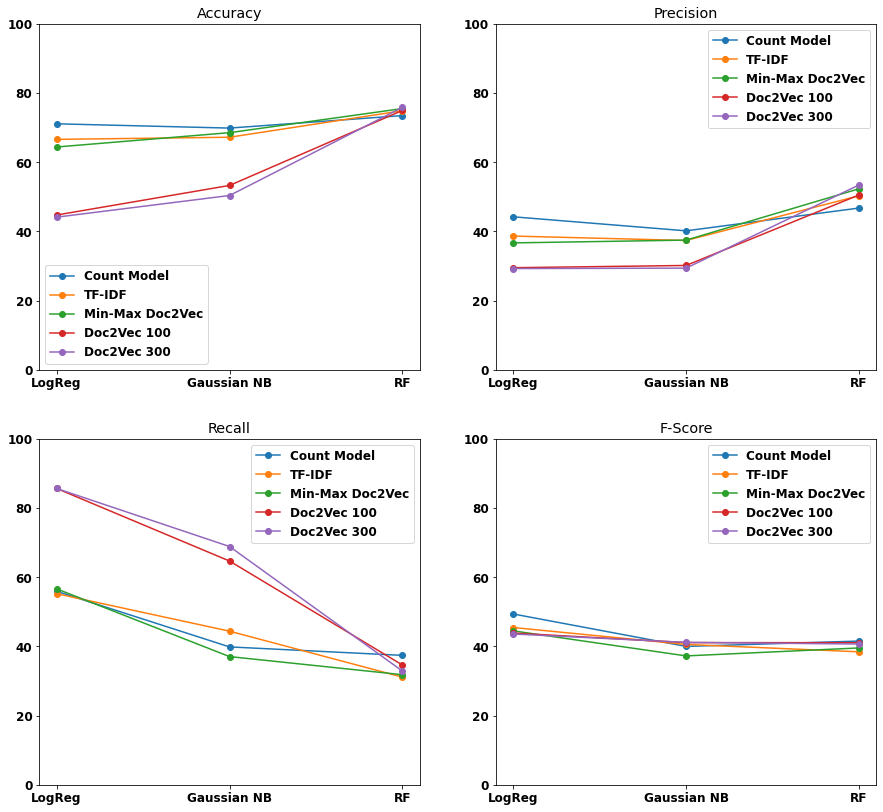

In [75]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
fig, ax = plt.subplots(2,2, figsize=(15,14))
ax[0][0].plot(final_accuracy.index,final_accuracy.loc[final_accuracy.index,:], marker = 'o')
ax[0][0].legend(final_accuracy.columns)
ax[0][0].set_ylim(0,100)
ax[0][0].set_title('Accuracy')
ax[0][1].plot(final_precision.index,final_precision.loc[final_precision.index,:], marker = 'o')
ax[0][1].legend(final_precision.columns)
ax[0][1].set_ylim(0,100)
ax[0][1].set_title('Precision')
ax[1][0].plot(final_recall.index,final_recall.loc[final_recall.index,:], marker = 'o')
ax[1][0].legend(final_recall.columns)
ax[1][0].set_ylim(0,100)
ax[1][0].set_title('Recall')
ax[1][1].plot(final_f1_score.index,final_f1_score.loc[final_f1_score.index,:], marker = 'o')
ax[1][1].legend(final_f1_score.columns)
ax[1][1].set_ylim(0,100)
ax[1][1].set_title('F-Score')
fig.show()
fig.savefig('Final_Model_Performance.eps',dpi=1200, bbox_inches = 'tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


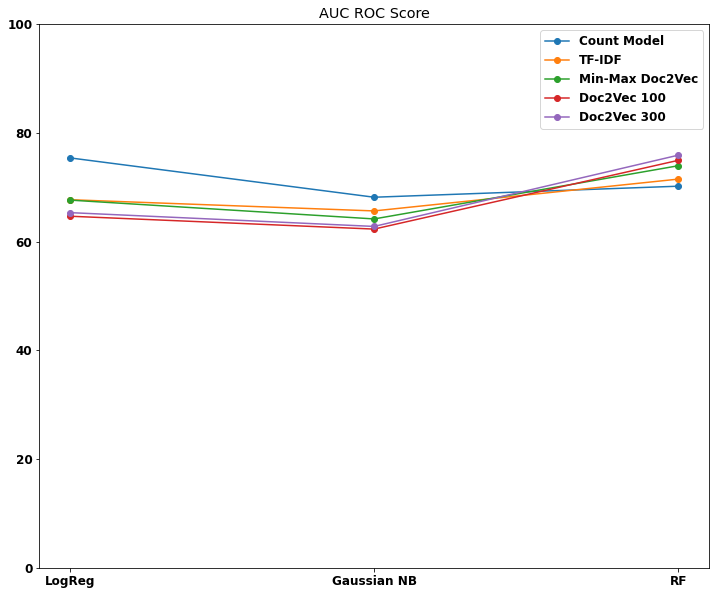

In [76]:
plt.figure(figsize = (12,10))
plt.plot(final_auc_roc.index,final_auc_roc.loc[final_auc_roc.index,:], marker = 'o')
plt.legend(final_auc_roc.columns)
plt.ylim(0,100)
plt.title('AUC ROC Score')
plt.savefig('Auc_Roc_Score_metric.eps', dpi = 1200, bbox_inches = 'tight')
plt.show()

### Graph for Text Models

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


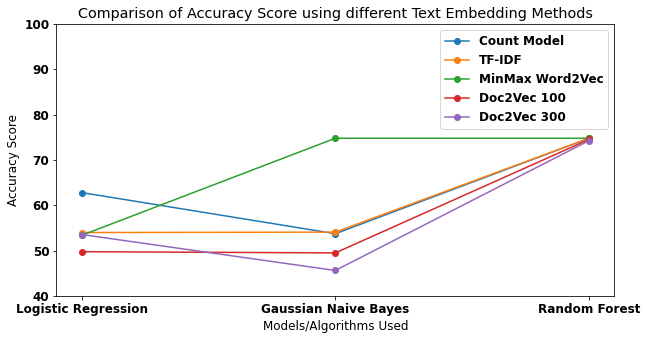

In [77]:
text_accuracy_score = {'Count Model':[accuracy_score(final_test_set['requester_received_pizza'],new_count_model_lr.predict(test_count_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_count_model_nbg.predict(test_count_df.toarray()))*100,accuracy_score(final_test_set['requester_received_pizza'],new_count_model_rf.predict(test_count_df))*100], 
                       'TF-IDF':[accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_lr.predict(test_tfidf_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_nbg.predict(test_tfidf_df.toarray()))*100,accuracy_score(final_test_set['requester_received_pizza'],new_tfidf_model_rf.predict(test_tfidf_df))*100],
                       'MinMax Word2Vec':[accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_lr.predict(test_minmax_word2vec_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_rf.predict(test_minmax_word2vec_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_minmax_word2vec_model_rf.predict(test_minmax_word2vec_df))*100],
                       'Doc2Vec 100':[accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_lr.predict(test_doc2vec_100_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_nbg.predict(test_doc2vec_100_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_100_model_rf.predict(test_doc2vec_100_df))*100],
                       'Doc2Vec 300':[accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_lr.predict(test_doc2vec_300_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_nbg.predict(test_doc2vec_300_df))*100,accuracy_score(final_test_set['requester_received_pizza'],new_doc2vec_300_model_rf.predict(test_doc2vec_300_df))*100]}
plot_data = pd.DataFrame(text_accuracy_score, index=['Logistic Regression','Gaussian Naive Bayes','Random Forest'])

fig = plt.figure(figsize=(10,5))
plt.plot(plot_data.index,plot_data.loc[plot_data.index,:], marker = 'o')
plt.ylim(40,100)
plt.title('Comparison of Accuracy Score using different Text Embedding Methods')
plt.xlabel('Models/Algorithms Used')
plt.ylabel('Accuracy Score')
plt.legend(plot_data.columns)
plt.savefig('AccScoreTextModel.eps', dpi=1200,bbox_inches='tight')
plt.show()